In [22]:

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


def counts_pct(y, classes):
    vc = pd.Series(y).value_counts().reindex(range(len(classes)), fill_value=0)
    df = pd.DataFrame({"label_id": vc.index, "count": vc.values})
    df["label"] = df["label_id"].map(dict(enumerate(classes)))
    df["percent"] = 100 * df["count"] / df["count"].sum()
    return df[["label", "count", "percent"]].set_index("label")


data = pd.read_csv("Dataset.csv")  


X = data.iloc[:, :30].copy()


y_raw = data.iloc[:, 30].astype(str).str.strip()

def simplify_flare(label):
    if label.startswith("C"):
        return "C"
    elif label.startswith("M"):
        return "M"
    elif label.startswith("X"):
        return "X"
    elif label in {"0", "0.0"}:
        return "0"
    else:
        return "Unknown"

y_simplified = y_raw.apply(simplify_flare)

# Drop "Unknown" labels
mask_known = y_simplified != "Unknown"
X = X.loc[mask_known].reset_index(drop=True)
y_simplified = y_simplified.loc[mask_known].reset_index(drop=True)

print("=== Overall class counts (before split) ===")
overall_counts = y_simplified.value_counts().to_frame("count")
overall_counts["percent"] = 100 * overall_counts["count"] / len(y_simplified)
print(overall_counts, "\n")


X = X.apply(pd.to_numeric, errors="coerce")

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_simplified)
class_names = list(encoder.classes_)

print("Encoded class mapping:", dict(zip(class_names, encoder.transform(class_names))), "\n")


data_clean = data.loc[mask_known].reset_index(drop=True)

data_clean["image_path"] = data_clean["image_path"].astype(str)
data_clean["ar_id"] = data_clean["image_path"].str.split("_", n=1).str[0]

print("Sample image_path + ar_id:")
print(data_clean[["image_path", "ar_id"]].head(), "\n")


ar_ids = data_clean["ar_id"].values
unique_ars = np.unique(ar_ids)


ar_indices = {}
ar_labels = {}
ar_counts = {}

for ar in unique_ars:
    idx = np.where(ar_ids == ar)[0]
    ar_indices[ar] = idx
    labels = set(np.unique(y_encoded[idx]))
    ar_labels[ar] = labels
    ar_counts[ar] = len(idx)

all_labels = set(np.unique(y_encoded))

print("All labels in dataset (encoded):", sorted(all_labels))
print("Label -> class name mapping:", dict(enumerate(class_names)))

# Quick sanity: we need at least 3 ARs for each class, otherwise impossible
for lbl in all_labels:
    ars_with_lbl = [ar for ar in unique_ars if lbl in ar_labels[ar]]
    if len(ars_with_lbl) < 3:
        raise RuntimeError(
            f"Class {lbl} ('{class_names[lbl]}') appears in only {len(ars_with_lbl)} AR(s). "
            "It is impossible to have this class in train, val, and test "
            "without AR overlap."
        )


n_total = len(X)
target_sizes = {
    "train": 0.6 * n_total,
    "val":   0.3 * n_total,
    "test":  0.1 * n_total,
}

splits = {
    "train": {"ars": set(), "rows": 0, "labels": set()},
    "val":   {"ars": set(), "rows": 0, "labels": set()},
    "test":  {"ars": set(), "rows": 0, "labels": set()},
}

def add_ar_to_split(split_name, ar):
    """Assign a given AR (by id) to a split, updating metadata."""
    if ar in splits["train"]["ars"] or ar in splits["val"]["ars"] or ar in splits["test"]["ars"]:
        raise RuntimeError(f"AR {ar} is being assigned to multiple splits.")
    splits[split_name]["ars"].add(ar)
    splits[split_name]["rows"] += ar_counts[ar]
    splits[split_name]["labels"].update(ar_labels[ar])


used_ars = set()

rng = np.random.default_rng(RANDOM_STATE)

for lbl in sorted(all_labels):
    
    candidate_ars = [ar for ar in unique_ars if (lbl in ar_labels[ar]) and (ar not in used_ars)]
  
    candidate_ars = sorted(candidate_ars, key=lambda a: -ar_counts[a])

    if len(candidate_ars) < 3:
        raise RuntimeError(
            f"After previous assignments, not enough ARs left for label {lbl} "
            f"('{class_names[lbl]}') to cover train/val/test separately."
        )

    
    chosen_for_label = candidate_ars[:3]

    for split_name, ar in zip(["train", "val", "test"], chosen_for_label):
        add_ar_to_split(split_name, ar)
        used_ars.add(ar)

print("\nAfter seeding by class:")
for split_name in ["train", "val", "test"]:
    print(
        f"  {split_name}: {len(splits[split_name]['ars'])} ARs, "
        f"{splits[split_name]['rows']} rows, "
        f"labels={sorted(splits[split_name]['labels'])}"
    )

remaining_ars = [ar for ar in unique_ars if ar not in used_ars]

for ar in remaining_ars:
    deficits = {
        split_name: target_sizes[split_name] - splits[split_name]["rows"]
        for split_name in ["train", "val", "test"]
    }
    best_split = max(deficits, key=deficits.get)
    add_ar_to_split(best_split, ar)

print("\nAfter assigning remaining ARs:")
for split_name in ["train", "val", "test"]:
    print(
        f"  {split_name}: {len(splits[split_name]['ars'])} ARs, "
        f"{splits[split_name]['rows']} rows, "
        f"labels={sorted(splits[split_name]['labels'])}"
    )

for split_name in ["train", "val", "test"]:
    lbls = splits[split_name]["labels"]
    if lbls != all_labels:
        raise RuntimeError(
            f"{split_name} does not contain all labels. "
            f"Has {sorted(lbls)}, expected {sorted(all_labels)}."
        )


train_mask = np.isin(ar_ids, list(splits["train"]["ars"]))
val_mask   = np.isin(ar_ids, list(splits["val"]["ars"]))
test_mask  = np.isin(ar_ids, list(splits["test"]["ars"]))

train_idx = np.where(train_mask)[0]
val_idx   = np.where(val_mask)[0]
test_idx  = np.where(test_mask)[0]

X_train, X_val, X_test = (
    X.iloc[train_idx],
    X.iloc[val_idx],
    X.iloc[test_idx],
)
y_train, y_val, y_test = (
    y_encoded[train_idx],
    y_encoded[val_idx],
    y_encoded[test_idx],
)

print("\nShapes:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "  y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  "  y_test: ", y_test.shape)


ars_train = splits["train"]["ars"]
ars_val   = splits["val"]["ars"]
ars_test  = splits["test"]["ars"]

overlap_train_val  = ars_train.intersection(ars_val)
overlap_train_test = ars_train.intersection(ars_test)
overlap_val_test   = ars_val.intersection(ars_test)

print("\n=== Active Region Overlap AFTER AR-based split ===")
print(f"Train–Validation overlap: {len(overlap_train_val)} ARs")
print(f"Train–Test overlap:       {len(overlap_train_test)} ARs")
print(f"Validation–Test overlap:  {len(overlap_val_test)} ARs")

if overlap_train_val or overlap_train_test or overlap_val_test:
    print("⚠️ Overlapping AR IDs detected (this should NOT happen).")
else:
    print("✅ No overlapping Active Regions – splits are leakage-free!")


print("\n=== Train class distribution ===")
print(counts_pct(y_train, class_names), "\n")

print("=== Validation class distribution ===")
print(counts_pct(y_val, class_names), "\n")

print("=== Test class distribution ===")
print(counts_pct(y_test, class_names), "\n")


dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

for split_name, X_split, y_split in [
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]:
    y_pred_dummy = dummy.predict(X_split)
    print(f"=== Majority-class baseline (DummyClassifier) on {split_name} ===")
    print("Accuracy:", accuracy_score(y_split, y_pred_dummy))
    print("Balanced accuracy:", balanced_accuracy_score(y_split, y_pred_dummy))
    print("Macro F1:", f1_score(y_split, y_pred_dummy, average="macro", zero_division=0), "\n")


C:\Users\User\AppData\Local\Temp\ipykernel_21316\595233773.py:28: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Dataset.csv")


=== Overall class counts (before split) ===
                count    percent
flare_strength                  
0               76142  79.071603
C               16977  17.630199
M                2578   2.677190
X                 598   0.621008 

Encoded class mapping: {'0': np.int64(0), 'C': np.int64(1), 'M': np.int64(2), 'X': np.int64(3)} 

Sample image_path + ar_id:
                                          image_path ar_id
0  1064_hmi.M_720s.20100501_000000_TAI.1.magnetog...  1064
1  1064_hmi.M_720s.20100501_001200_TAI.1.magnetog...  1064
2  1064_hmi.M_720s.20100501_002400_TAI.1.magnetog...  1064
3  1064_hmi.M_720s.20100501_003600_TAI.1.magnetog...  1064
4  1064_hmi.M_720s.20100501_004800_TAI.1.magnetog...  1064 

All labels in dataset (encoded): [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Label -> class name mapping: {0: '0', 1: 'C', 2: 'M', 3: 'X'}

After seeding by class:
  train: 4 ARs, 4075 rows, labels=[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
  val: 4 ARs, 3

In [23]:
print("Train labels:", sorted(set(y_train)))
print("Val labels:", sorted(set(y_val)))
print("Test labels:", sorted(set(y_test)))
print("Overall labels:", sorted(set(y_encoded)))


Train labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Val labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Test labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Overall labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


XGBoost alone, before tuning the hyperparameters:


=== Training XGBoost model ===


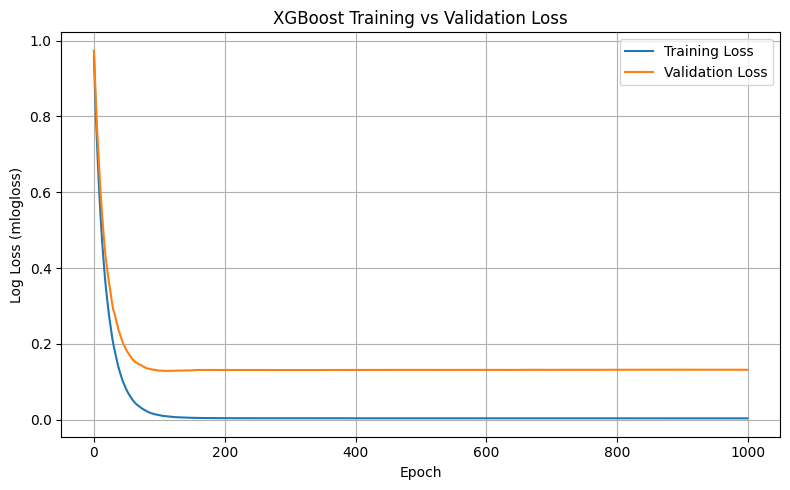


=== XGBoost (Validation set) performance ===
Accuracy: 0.9612582438451711
Balanced accuracy: 0.4707423015891268
Macro F1: 0.4776311831774167

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.00      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.49      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



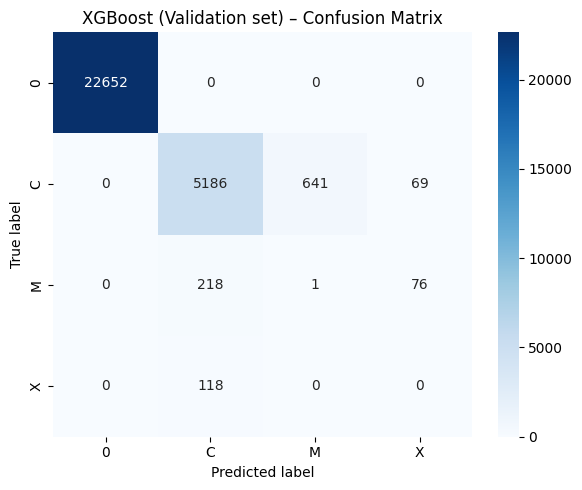


=== XGBoost (Test set) performance ===
Accuracy: 0.9334970111016225
Balanced accuracy: 0.6514891090019843
Macro F1: 0.5832617063198511

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.85      0.84      0.84      2001
           M       0.36      0.77      0.49       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.55      0.65      0.58      9368
weighted avg       0.93      0.93      0.93      9368



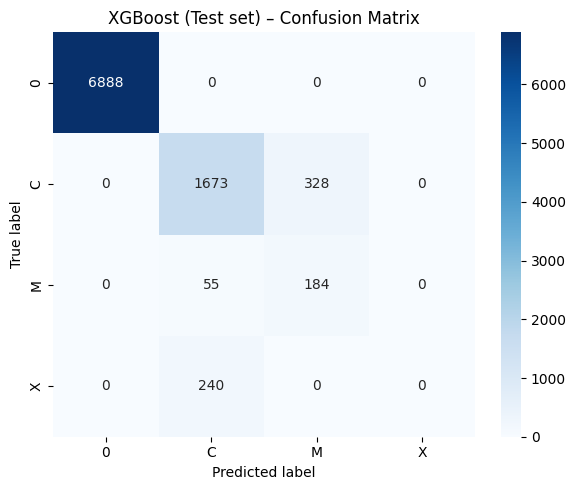

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
# Pipeline: impute -> scale -> XGBoost
xgb_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",       
        num_class=len(class_names),         
        eval_metric="mlogloss",            
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=6,
        subsample=0.5,
        colsample_bytree=0.8,
        gamma=1,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("\n=== Training XGBoost model ===")

xgb_model.fit(X_train, y_train)


imputer = xgb_model.named_steps["imputer"]
scaler = xgb_model.named_steps["scaler"]

X_train_proc = scaler.transform(imputer.transform(X_train))
X_val_proc   = scaler.transform(imputer.transform(X_val))

xgb_for_plot = XGBClassifier(
    objective="multi:softmax",
    num_class=len(class_names),   
    eval_metric="mlogloss",
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=10,
    subsample=0.5,
    colsample_bytree=0.8,
    gamma=1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


xgb_for_plot.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)


results = xgb_for_plot.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("XGBoost Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(
        classification_report(
            y_split,
            y_pred,
            labels=range(len(class_names)),   # force 0,1,2,3
            target_names=class_names,
            zero_division=0
        )
    )

  
    cm = confusion_matrix(
        y_split,
        y_pred,
        labels=range(len(class_names))
    )

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost (Validation set)", xgb_model, X_val, y_val)
eval_model("XGBoost (Test set)", xgb_model, X_test, y_test)


After tuning the hyperparameters:


=== Hyperparameter tuning with GridSearchCV (macro F1) ===
Fitting 3 folds for each of 192 candidates, totalling 576 fits

Best macro F1 (CV on train): 0.6503384907601686
Best params:
  clf__colsample_bytree: 0.8
  clf__gamma: 0.1
  clf__learning_rate: 0.2
  clf__max_depth: 4
  clf__n_estimators: 50
  clf__reg_lambda: 0.5
  clf__subsample: 1.0


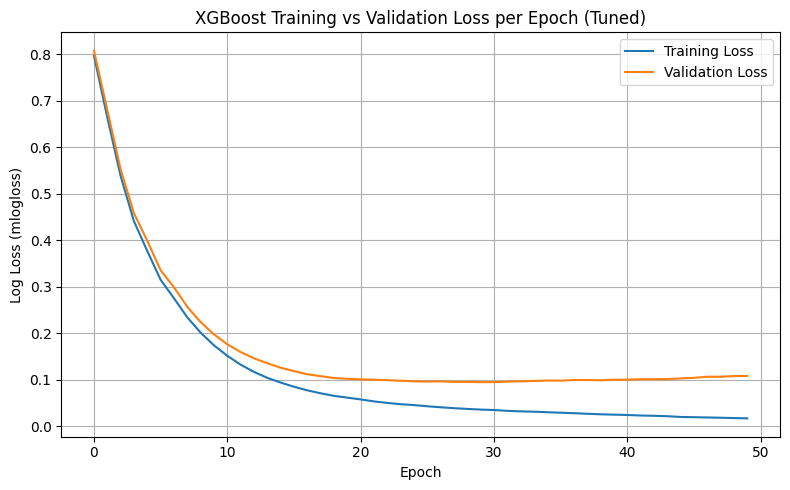


=== XGBoost (Validation set, tuned) performance ===
Accuracy: 0.9698214840647768
Balanced accuracy: 0.4820629613872088
Macro F1: 0.4831867078530322

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.93      0.92      0.93      5896
           M       0.00      0.01      0.01       295
           X       0.00      0.00      0.00       118

    accuracy                           0.97     28961
   macro avg       0.48      0.48      0.48     28961
weighted avg       0.97      0.97      0.97     28961



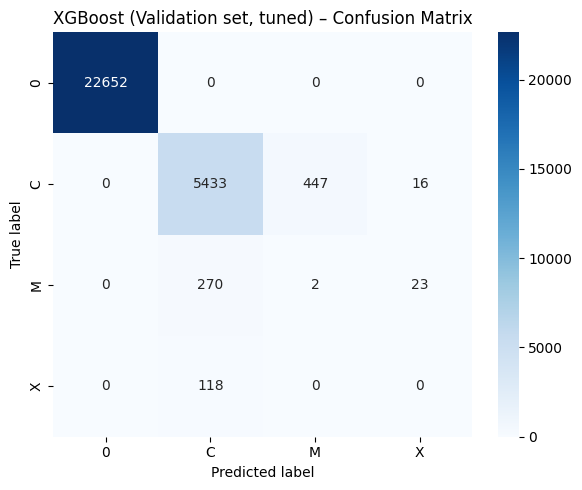


=== XGBoost (Test set, tuned) performance ===
Accuracy: 0.9310418445772843
Balanced accuracy: 0.6384835824765441
Macro F1: 0.5743259909059711

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.83      0.84      2001
           M       0.34      0.72      0.46       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.55      0.64      0.57      9368
weighted avg       0.92      0.93      0.93      9368



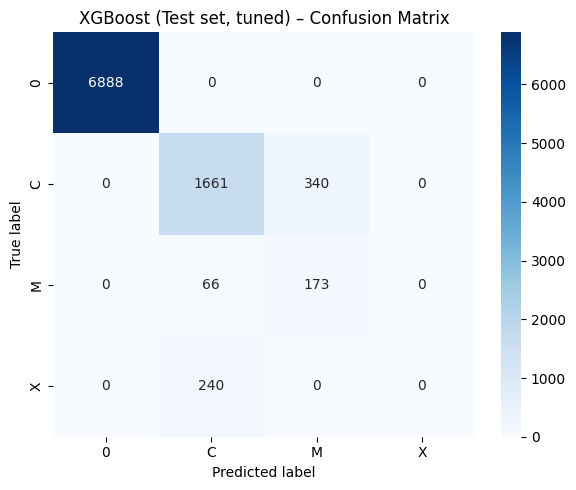

In [25]:
from xgboost import XGBClassifier
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE  
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns



xgb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=len(class_names),
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])


param_grid = {
    "clf__learning_rate":   [0.05, 0.1, 0.2],
    "clf__n_estimators":    [50, 100],
    "clf__max_depth":       [4, 6],
    "clf__subsample":       [0.8, 1.0],
    "clf__colsample_bytree":[0.8, 1.0],
    "clf__gamma":           [0.0, 0.1],
    "clf__reg_lambda":      [1.0, 0.5],
}

print("\n=== Hyperparameter tuning with GridSearchCV (macro F1) ===")
grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,                 
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest macro F1 (CV on train):", grid.best_score_)
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_pipeline = grid.best_estimator_


best_imputer = best_pipeline.named_steps["imputer"]
best_scaler  = best_pipeline.named_steps["scaler"]
best_clf     = best_pipeline.named_steps["clf"]

X_train_proc = best_scaler.transform(best_imputer.transform(X_train))
X_val_proc   = best_scaler.transform(best_imputer.transform(X_val))


best_xgb_params = best_clf.get_params()

xgb_loss_model = XGBClassifier(
    **{
        # keep core params explicitly
        "objective": "multi:softmax",
        "num_class": len(class_names),
        "eval_metric": "mlogloss",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        # plus the tuned hyperparameters
        "learning_rate":   best_xgb_params["learning_rate"],
        "n_estimators":    best_xgb_params["n_estimators"],
        "max_depth":       best_xgb_params["max_depth"],
        "subsample":       best_xgb_params["subsample"],
        "colsample_bytree":best_xgb_params["colsample_bytree"],
        "gamma":           best_xgb_params["gamma"],
        "reg_lambda":      best_xgb_params["reg_lambda"],
    }
)

xgb_loss_model.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)


results = xgb_loss_model.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("XGBoost Training vs Validation Loss per Epoch (Tuned)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost (Validation set, tuned)", best_pipeline, X_val, y_val)
eval_model("XGBoost (Test set, tuned)",       best_pipeline, X_test, y_test)


We are using SMOTE, which is a strategy that increase the number of sample from classes that are not very present in the data by synthetically adding instances of these in the training dataset. 

Class dist BEFORE SMOTE: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Full SMOTE sampling_strategy: {np.int64(0): 46602, np.int64(1): 46602, np.int64(2): 46602, np.int64(3): 46602}
Class dist AFTER SMOTE: Counter({np.int64(0): 46602, np.int64(1): 46602, np.int64(2): 46602, np.int64(3): 46602}) 

=== Hyperparameter tuning on validation set (macro F1) ===
New best macro F1=0.4772 with params: lr=0.05, n_estimators=50, max_depth=4, subsample=0.8, colsample_bytree=0.8, gamma=0.0
New best macro F1=0.4886 with params: lr=0.05, n_estimators=50, max_depth=6, subsample=0.8, colsample_bytree=0.8, gamma=0.0
New best macro F1=0.5001 with params: lr=0.05, n_estimators=50, max_depth=6, subsample=0.8, colsample_bytree=1.0, gamma=0.0
New best macro F1=0.5044 with params: lr=0.05, n_estimators=50, max_depth=6, subsample=1.0, colsample_bytree=1.0, gamma=0.0
N

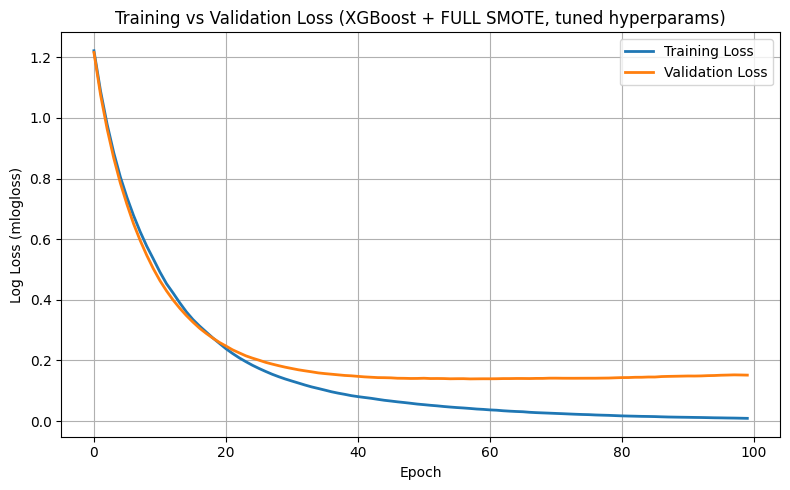


=== XGBoost + FULL SMOTE (Validation, tuned hyperparams) performance ===
Accuracy: 0.9612582438451711
Balanced accuracy: 0.5238759975162708
Macro F1: 0.5060747077536558

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.87      0.90      5896
           M       0.08      0.23      0.12       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.51      0.52      0.51     28961
weighted avg       0.97      0.96      0.97     28961



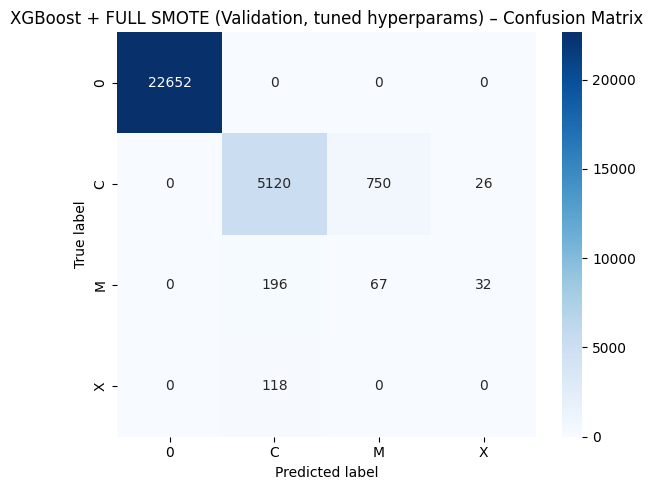


=== XGBoost + FULL SMOTE (Test, tuned hyperparams) performance ===
Accuracy: 0.9279461998292058
Balanced accuracy: 0.6735373552763367
Macro F1: 0.5837646330804098

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.86      0.79      0.82      2001
           M       0.34      0.89      0.49       239
           X       1.00      0.01      0.02       240

    accuracy                           0.93      9368
   macro avg       0.80      0.67      0.58      9368
weighted avg       0.95      0.93      0.92      9368



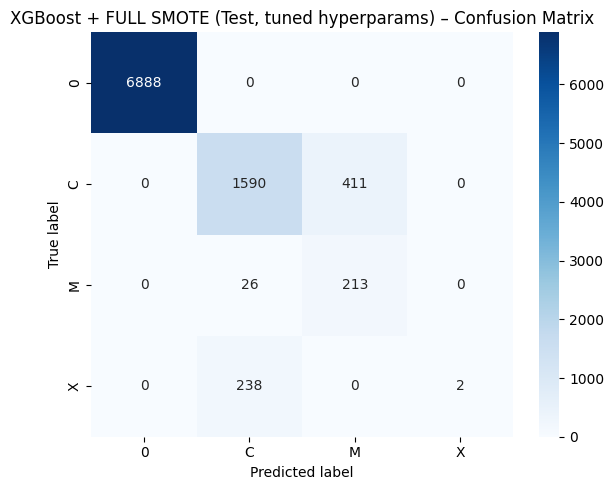

In [26]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42  

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("Class dist BEFORE SMOTE:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution:", class_dist)

max_count = max(class_dist.values())
sampling_strategy = {cls: max_count for cls in class_dist.keys()}

print("Full SMOTE sampling_strategy:", sampling_strategy)

sm = SMOTE(
    random_state=RANDOM_STATE,
    sampling_strategy=sampling_strategy,
    k_neighbors=3
)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Class dist AFTER SMOTE:", Counter(y_train_res), "\n")


base_params = dict(
    objective="multi:softmax",
    num_class=len(class_names),
    eval_metric="mlogloss",
    reg_lambda=0.5,
    reg_alpha=0.1,
    min_child_weight=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators":  [50, 100],
    "max_depth":     [4, 6],
    "subsample":     [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma":         [0.0, 0.1]
}

best_score = -np.inf
best_params = None

print("=== Hyperparameter tuning on validation set (macro F1) ===")
for lr in param_grid["learning_rate"]:
    for n_est in param_grid["n_estimators"]:
        for md in param_grid["max_depth"]:
            for ss in param_grid["subsample"]:
                for cs in param_grid["colsample_bytree"]:
                    for gm in param_grid["gamma"]:
                        params = base_params.copy()
                        params.update(
                            learning_rate=lr,
                            n_estimators=n_est,
                            max_depth=md,
                            subsample=ss,
                            colsample_bytree=cs,
                            gamma=gm
                        )

                        model = XGBClassifier(**params)
                        model.fit(X_train_res, y_train_res)

                        # Evaluate on validation
                        y_val_pred = model.predict(X_val_scaled)
                        macro_f1 = f1_score(
                            y_val,
                            y_val_pred,
                            average="macro",
                            zero_division=0
                        )

                        if macro_f1 > best_score:
                            best_score = macro_f1
                            best_params = params.copy()

                            print(
                                f"New best macro F1={best_score:.4f} "
                                f"with params: lr={lr}, n_estimators={n_est}, "
                                f"max_depth={md}, subsample={ss}, "
                                f"colsample_bytree={cs}, gamma={gm}"
                            )

print("\nBest validation macro F1:", best_score)
print("Best params:", best_params)


xgb_best = XGBClassifier(**best_params)

xgb_best.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_best.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + FULL SMOTE, tuned hyperparams)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost + FULL SMOTE (Validation, tuned hyperparams)", xgb_best, X_val_scaled, y_val)
eval_model("XGBoost + FULL SMOTE (Test, tuned hyperparams)",       xgb_best, X_test_scaled, y_test)


Having seen that SMOTE did not yield any good results, we thought about why that might be, and we came to the conclusion that since we are oversampling all the different classes, that does not give X and M any advantage to become better represented. 
For this reason, our next step is to oversample X.

Initial class distribution:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

After ensuring X in TRAIN and TEST:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

Class dist BEFORE SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution (TRAIN): Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Sampling strategy for SMOTE (X only): {3: 1200}
Class dist AFTER SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, 

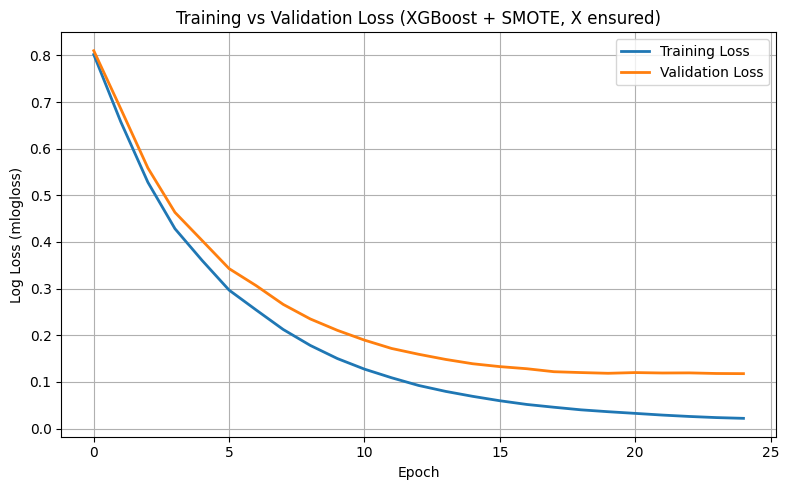


=== XGBoost + SMOTE (Validation) performance ===
Accuracy: 0.9616380649839439
Balanced accuracy: 0.4720137754984707
Macro F1: 0.4780756074436931

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.01      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.48      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



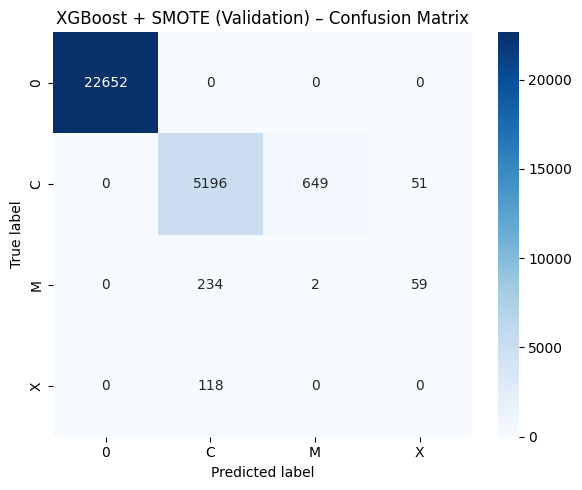


=== XGBoost + SMOTE (Test) performance ===
Accuracy: 0.9275192143467123
Balanced accuracy: 0.6371239066659139
Macro F1: 0.5680472025738785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.81      0.83      2001
           M       0.32      0.74      0.45       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.54      0.64      0.57      9368
weighted avg       0.92      0.93      0.92      9368



c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

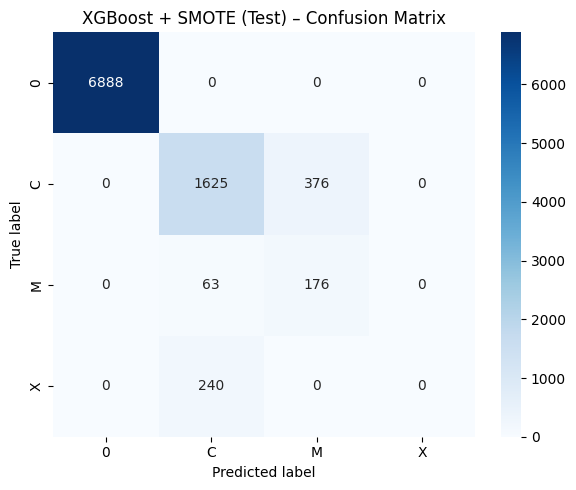

In [ ]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns




label_X = class_names.index("X")  


X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)

y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)
y_test  = np.asarray(y_test)

print("Initial class distribution:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


if label_X not in np.unique(y_train):
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) == 0:
        print(f"[WARNING] No X samples in VAL to move into TRAIN.")
    else:
        n_move_train = max(1, len(idx_x_val) // 3)
        move_idx_train = idx_x_val[:n_move_train]

        print(f"Moving {n_move_train} X samples from VAL to TRAIN.")

        X_train = np.concatenate([X_train, X_val[move_idx_train]], axis=0)
        y_train = np.concatenate([y_train, y_val[move_idx_train]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_train] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]


if label_X not in np.unique(y_test):
 
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) > 0:
        n_move_test = max(1, len(idx_x_val) // 3)
        move_idx_test = idx_x_val[:n_move_test]

        print(f"Moving {n_move_test} X samples from VAL to TEST.")

        
        X_test = np.concatenate([X_test, X_val[move_idx_test]], axis=0)
        y_test = np.concatenate([y_test, y_val[move_idx_test]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_test] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]
    else:
        
        idx_x_train = np.where(y_train == label_X)[0]
        if len(idx_x_train) > 1:
            n_move_test = 1  
            move_idx_test = idx_x_train[:n_move_test]

            print(f"Moving {n_move_test} X sample from TRAIN to TEST.")

          
            X_test = np.concatenate([X_test, X_train[move_idx_test]], axis=0)
            y_test = np.concatenate([y_test, y_train[move_idx_test]], axis=0)

         
            mask_train = np.ones(len(y_train), dtype=bool)
            mask_train[move_idx_test] = False
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
        else:
            print(f"[WARNING] Could not ensure X in TEST (too few X samples globally).")

print("\nAfter ensuring X in TRAIN and TEST:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("\nClass dist BEFORE SMOTE on TRAIN:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution (TRAIN):", class_dist)

sampling_strategy = None
k_neighbors = 3

if label_X in class_dist and class_dist[label_X] > k_neighbors:
    x_count = class_dist[label_X]
    # Oversample X, e.g. 5x (you can tune this factor)
    target_x = x_count * 5    
    sampling_strategy = {label_X: target_x}
    print("Sampling strategy for SMOTE (X only):", sampling_strategy)

    sm = SMOTE(
        random_state=RANDOM_STATE,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors
    )
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print("Class dist AFTER SMOTE on TRAIN:", Counter(y_train_res), "\n")
else:
    print(f"[WARNING] Too few X samples in TRAIN for SMOTE (need > {k_neighbors}).")
    X_train_res, y_train_res = X_train_scaled, y_train


xgb_smote = XGBClassifier(
    objective="multi:softmax",       # Multi-class classification
    num_class=len(class_names),      # Number of classes in your dataset
    eval_metric="mlogloss",          # Log-loss metric for multi-class classification
    learning_rate=0.2,               # Learning rate
    n_estimators=25,                # Number of boosting rounds
    max_depth=6,                     # Depth of each tree, controls model complexity
    subsample=0.8,                   # Randomly sample a portion of the training set for each tree
    colsample_bytree=0.8,            # Randomly sample features for each tree
    gamma=0.1,                       # Minimum loss reduction required to make a further partition
    reg_lambda=0.5,                  # L2 regularization to prevent overfitting
    reg_alpha=0.1,                   # L1 regularization to encourage sparsity
    min_child_weight=1,              # Minimum sum of instance weight (hessian) in a child
    random_state=RANDOM_STATE,       # Ensure reproducibility
    n_jobs=-1                        # Use all CPU threads for training
)


xgb_smote.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_smote.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + SMOTE, X ensured)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label"); plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix"); plt.tight_layout(); plt.show()

eval_model("XGBoost + SMOTE (Validation)", xgb_smote, X_val_scaled, y_val)
eval_model("XGBoost + SMOTE (Test)",       xgb_smote, X_test_scaled, y_test)


In this case, we are using class weights to penalize the loss on minority classes.

Initial class distribution:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

After ensuring X in TRAIN and TEST:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

Class dist BEFORE SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution (TRAIN): Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Sampling strategy for SMOTE (X only): {3: 1200}
Class dist AFTER SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, 

c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:49:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


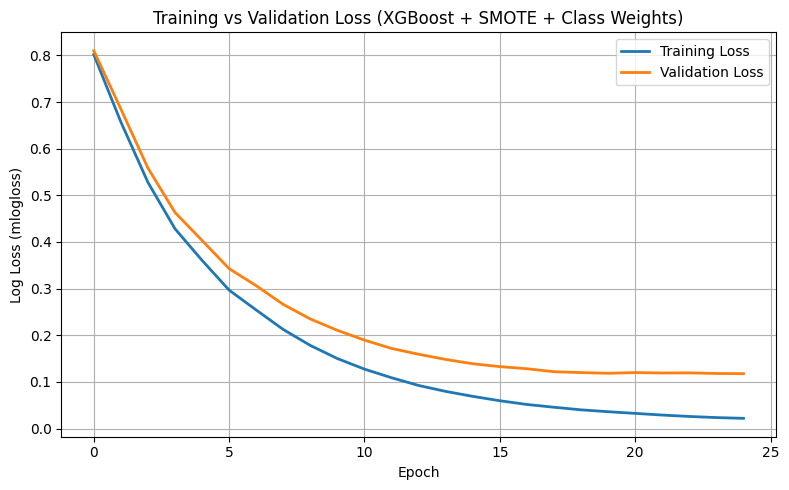


=== XGBoost + SMOTE (Validation) performance ===
Accuracy: 0.9616380649839439
Balanced accuracy: 0.4720137754984707
Macro F1: 0.4780756074436931

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.01      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.48      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



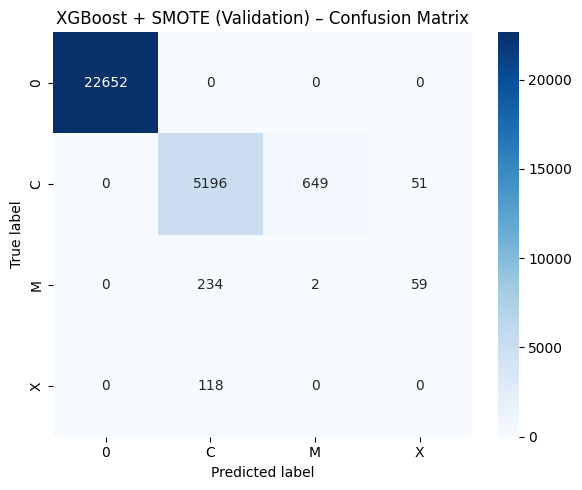


=== XGBoost + SMOTE (Test) performance ===
Accuracy: 0.9275192143467123
Balanced accuracy: 0.6371239066659139
Macro F1: 0.5680472025738785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.81      0.83      2001
           M       0.32      0.74      0.45       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.54      0.64      0.57      9368
weighted avg       0.92      0.93      0.92      9368



c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

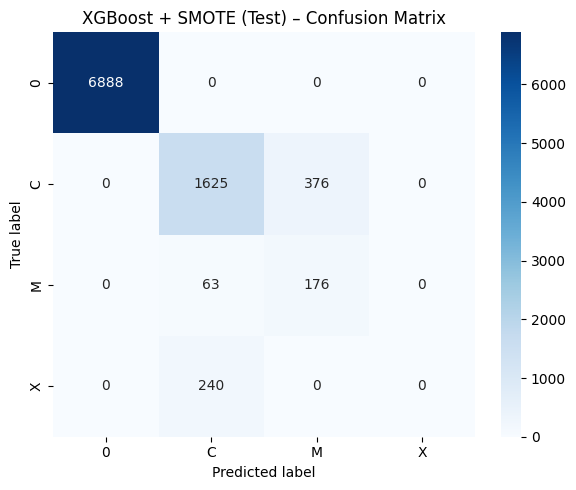

In [28]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns




label_X = class_names.index("X")  


X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)

y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)
y_test  = np.asarray(y_test)

print("Initial class distribution:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


if label_X not in np.unique(y_train):
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) == 0:
        print(f"[WARNING] No X samples in VAL to move into TRAIN.")
    else:
        n_move_train = max(1, len(idx_x_val) // 3)
        move_idx_train = idx_x_val[:n_move_train]

        print(f"Moving {n_move_train} X samples from VAL to TRAIN.")

        X_train = np.concatenate([X_train, X_val[move_idx_train]], axis=0)
        y_train = np.concatenate([y_train, y_val[move_idx_train]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_train] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]


if label_X not in np.unique(y_test):
 
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) > 0:
        n_move_test = max(1, len(idx_x_val) // 3)
        move_idx_test = idx_x_val[:n_move_test]

        print(f"Moving {n_move_test} X samples from VAL to TEST.")

        
        X_test = np.concatenate([X_test, X_val[move_idx_test]], axis=0)
        y_test = np.concatenate([y_test, y_val[move_idx_test]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_test] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]
    else:
        
        idx_x_train = np.where(y_train == label_X)[0]
        if len(idx_x_train) > 1:
            n_move_test = 1  
            move_idx_test = idx_x_train[:n_move_test]

            print(f"Moving {n_move_test} X sample from TRAIN to TEST.")

          
            X_test = np.concatenate([X_test, X_train[move_idx_test]], axis=0)
            y_test = np.concatenate([y_test, y_train[move_idx_test]], axis=0)

         
            mask_train = np.ones(len(y_train), dtype=bool)
            mask_train[move_idx_test] = False
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
        else:
            print(f"[WARNING] Could not ensure X in TEST (too few X samples globally).")

print("\nAfter ensuring X in TRAIN and TEST:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("\nClass dist BEFORE SMOTE on TRAIN:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution (TRAIN):", class_dist)

sampling_strategy = None
k_neighbors = 3

if label_X in class_dist and class_dist[label_X] > k_neighbors:
    x_count = class_dist[label_X]
    # Oversample X, e.g. 5x (you can tune this factor)
    target_x = x_count * 5    
    sampling_strategy = {label_X: target_x}
    print("Sampling strategy for SMOTE (X only):", sampling_strategy)

    sm = SMOTE(
        random_state=RANDOM_STATE,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors
    )
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print("Class dist AFTER SMOTE on TRAIN:", Counter(y_train_res), "\n")
else:
    print(f"[WARNING] Too few X samples in TRAIN for SMOTE (need > {k_neighbors}).")
    X_train_res, y_train_res = X_train_scaled, y_train
    


weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_res),
    y=y_train_res
)

class_weights = {i: w for i, w in enumerate(weights)}
print(class_weights)


xgb_smote = XGBClassifier(
    objective="multi:softmax",       # Multi-class classification
    num_class=len(class_names),      # Number of classes in your dataset
    eval_metric="mlogloss",          # Log-loss metric for multi-class classification
    learning_rate=0.2,               # Learning rate
    n_estimators=25,                # Number of boosting rounds
    max_depth=6,                     # Depth of each tree, controls model complexity
    subsample=0.8,                   # Randomly sample a portion of the training set for each tree
    colsample_bytree=0.8,            # Randomly sample features for each tree
    gamma=0.1,                       # Minimum loss reduction required to make a further partition
    reg_lambda=0.5,                  # L2 regularization to prevent overfitting
    reg_alpha=0.1,                   # L1 regularization to encourage sparsity
    min_child_weight=1,              # Minimum sum of instance weight (hessian) in a child
    random_state=RANDOM_STATE,       # Ensure reproducibility
    n_jobs=-1, 
    class_weight = class_weights# Use all CPU threads for training
)


xgb_smote.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_smote.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + SMOTE + Class Weights)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label"); plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix"); plt.tight_layout(); plt.show()

# ---------------------------------------------------------
# 5) Evaluate (no SMOTE on val/test)
# ---------------------------------------------------------
eval_model("XGBoost + SMOTE (Validation)", xgb_smote, X_val_scaled, y_val)
eval_model("XGBoost + SMOTE (Test)",       xgb_smote, X_test_scaled, y_test)
